# Multivariate Modeling Using RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [2]:
#mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#import campus5

df = pd.read_csv('campus5.csv')

In [5]:
df.index = pd.to_datetime(df['Timestamp'])
df.drop(columns = ['Timestamp', 'CampusKey', 'time'], inplace = True)
df.shape

(79319, 7)

In [6]:
#ww stands for With Weather info. Which starts at index #33311
#Interpolating any missing weather interval data
ww = df.iloc[33311:]
ww = ww.interpolate(method = 'linear', limit_direction = 'forward')
ww.isnull().sum()

SolarGeneration        0
ApparentTemperature    0
AirTemperature         0
DewPointTemperature    0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
dtype: int64

In [7]:
#Setting X and Y
features = [i for i in ww.columns if i != 'SolarGeneration']
X = ww[features]
y = ww['SolarGeneration']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

In [8]:
X_train.iloc[-1]

ApparentTemperature     14.100000
AirTemperature          17.200000
DewPointTemperature     12.200000
RelativeHumidity        72.500000
WindSpeed               18.318182
WindDirection          220.363636
Name: 2022-01-18 03:15:00, dtype: float64

In [9]:
X_test.iloc[0]

ApparentTemperature     13.900000
AirTemperature          17.000000
DewPointTemperature     12.100000
RelativeHumidity        73.000000
WindSpeed               18.318182
WindDirection          220.363636
Name: 2022-01-18 03:30:00, dtype: float64

In [10]:
#Standard Scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [11]:
def print_last(res):
  '''
  Helper function to just print out the last training and testing loss 
  function values as well as the last metrics of a fitted model
  '''
  print(f"Mean Absolute Error - Training: {np.round(res.history['loss'][-1], 5)}")
  print(f"Mean Absolute Error - Testing: {np.round(res.history['val_loss'][-1], 5)}")
  print(f"Root Mean Squared Error - Training: {np.round(np.sqrt(res.history['mse'][-1]), 5)}")
  print(f"Root Mean Squared Error - Testing: {np.round(np.sqrt(res.history['val_mse'][-1]), 5)}")

First investigating sequences 4 intervals long (1 hour)

In [12]:
#timeseries generator, input shape, and early stopping for modeling

train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 4, batch_size = 64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 4, batch_size = 64)
input_shape = train_sequences[0][0][0].shape
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [13]:
model = Sequential()

model.add(LSTM(96, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Mean Absolute Error - Training: 0.95058
Mean Absolute Error - Testing: 0.75021
Root Mean Squared Error - Training: 1.76877
Root Mean Squared Error - Testing: 1.2032


In [14]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.05637
Mean Absolute Error - Testing: 1.09387
Root Mean Squared Error - Training: 1.90334
Root Mean Squared Error - Testing: 1.65777


In [15]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.04678
Mean Absolute Error - Testing: 1.43587
Root Mean Squared Error - Training: 1.89877
Root Mean Squared Error - Testing: 2.19031


In [16]:
model = Sequential()

model.add(LSTM(32, input_shape = input_shape, return_sequences = True, ))
model.add(LSTM(32, input_shape = input_shape, return_sequences = True))
model.add(LSTM(64, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.05795
Mean Absolute Error - Testing: 1.03635
Root Mean Squared Error - Training: 1.91572
Root Mean Squared Error - Testing: 1.59709


In [17]:
model = Sequential()

model.add(LSTM(32, input_shape = input_shape, return_sequences = True))
model.add(LSTM(64, input_shape = input_shape, return_sequences = True))
model.add(LSTM(96, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.04467
Mean Absolute Error - Testing: 1.19123
Root Mean Squared Error - Training: 1.89839
Root Mean Squared Error - Testing: 1.8416


Investigating sequences of 16 intervals in length (4 hours)

In [18]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 16, batch_size = 96)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 16, batch_size = 96)
input_shape = train_sequences[0][0][0].shape

In [19]:
model = Sequential()

model.add(LSTM(96, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.86862
Mean Absolute Error - Testing: 0.4533
Root Mean Squared Error - Training: 1.70643
Root Mean Squared Error - Testing: 0.87734


In [20]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(8, activation = 'relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.92631
Mean Absolute Error - Testing: 0.55831
Root Mean Squared Error - Training: 1.76034
Root Mean Squared Error - Testing: 1.09514


In [21]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.98472
Mean Absolute Error - Testing: 0.84456
Root Mean Squared Error - Training: 1.83103
Root Mean Squared Error - Testing: 1.50587


In [22]:
model = Sequential()

model.add(LSTM(96, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.96265
Mean Absolute Error - Testing: 0.64295
Root Mean Squared Error - Training: 1.80217
Root Mean Squared Error - Testing: 1.17965


In [23]:
model = Sequential()

model.add(LSTM(32, input_shape = input_shape, return_sequences = True, ))
model.add(LSTM(32, input_shape = input_shape, return_sequences = True))
model.add(LSTM(64, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.93163
Mean Absolute Error - Testing: 0.65461
Root Mean Squared Error - Training: 1.76791
Root Mean Squared Error - Testing: 1.17058


Investigating sequences of 96 intervals in length (1 Day)

In [24]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 96, batch_size = 672)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 96, batch_size = 672)
input_shape = train_sequences[0][0][0].shape

In [25]:
model = Sequential()

model.add(LSTM(96, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.94868
Mean Absolute Error - Testing: 0.69396
Root Mean Squared Error - Training: 1.75809
Root Mean Squared Error - Testing: 1.0935


In [26]:
model = Sequential()

model.add(LSTM(192, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.93513
Mean Absolute Error - Testing: 0.59613
Root Mean Squared Error - Training: 1.75101
Root Mean Squared Error - Testing: 1.05542


In [27]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(8, activation = 'relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.97813
Mean Absolute Error - Testing: 0.69321
Root Mean Squared Error - Training: 1.82605
Root Mean Squared Error - Testing: 1.14853


In [28]:
model = Sequential()

model.add(LSTM(8, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.0601
Mean Absolute Error - Testing: 0.88665
Root Mean Squared Error - Training: 1.93375
Root Mean Squared Error - Testing: 1.47313


In [29]:
model = Sequential()

model.add(LSTM(32, input_shape = input_shape, return_sequences = True, ))
model.add(LSTM(32, input_shape = input_shape, return_sequences = True))
model.add(LSTM(64, input_shape = input_shape, return_sequences = False))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(512, activation ='relu'))
model.add(Dense(512, activation ='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.97408
Mean Absolute Error - Testing: 0.71907
Root Mean Squared Error - Training: 1.80524
Root Mean Squared Error - Testing: 1.29748


It seems Univariate Modeling gives much better scores. Probably due to the weather data variability compounding to the variability of the Solar Generation

---
# Hourly Modeling
---

In [30]:
hourly = ww.resample('H').mean().ffill()

In [31]:
features = [i for i in hourly.columns if i != 'SolarGeneration']
X = hourly[features]
y = hourly['SolarGeneration']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

In [32]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

First investigating 12-hour sequences

In [33]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 12, batch_size = 48)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 12, batch_size = 48)
input_shape = train_sequences[0][0][0].shape

In [34]:
model = Sequential()

model.add(LSTM(24, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Mean Absolute Error - Training: 0.90458
Mean Absolute Error - Testing: 0.64632
Root Mean Squared Error - Training: 1.66717
Root Mean Squared Error - Testing: 1.02747


In [35]:
model = Sequential()

model.add(LSTM(48, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.8885
Mean Absolute Error - Testing: 0.69227
Root Mean Squared Error - Training: 1.65965
Root Mean Squared Error - Testing: 1.12003


In [36]:
model = Sequential()

model.add(LSTM(144, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.89005
Mean Absolute Error - Testing: 0.65903
Root Mean Squared Error - Training: 1.65448
Root Mean Squared Error - Testing: 0.97003


Investigating 24-hour sequences

In [37]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 24, batch_size = 72)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 24, batch_size = 72)
input_shape = train_sequences[0][0][0].shape

In [38]:
model = Sequential()

model.add(LSTM(24, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.92665
Mean Absolute Error - Testing: 0.70469
Root Mean Squared Error - Training: 1.68173
Root Mean Squared Error - Testing: 1.00383


In [39]:
model = Sequential()

model.add(LSTM(48, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.88347
Mean Absolute Error - Testing: 0.54571
Root Mean Squared Error - Training: 1.63559
Root Mean Squared Error - Testing: 0.86451


In [40]:
model = Sequential()

model.add(LSTM(144, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 0.89581
Mean Absolute Error - Testing: 0.5185
Root Mean Squared Error - Training: 1.65761
Root Mean Squared Error - Testing: 0.84002


---
# Daily Investigation
---

In [41]:
daily = df.resample('D').max()

In [42]:
features = [i for i in ww.columns if i != 'SolarGeneration']
X = ww[features]
y = ww['SolarGeneration']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

In [43]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

First looking at 4-day sequences

In [44]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 4, batch_size = 12)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 4, batch_size = 12)
input_shape = train_sequences[0][0][0].shape

In [45]:
model = Sequential()

model.add(LSTM(10, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Mean Absolute Error - Training: 1.03026
Mean Absolute Error - Testing: 1.02375
Root Mean Squared Error - Training: 1.8525
Root Mean Squared Error - Testing: 1.54773


In [46]:
model = Sequential()

model.add(LSTM(30, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.02348
Mean Absolute Error - Testing: 1.02705
Root Mean Squared Error - Training: 1.83331
Root Mean Squared Error - Testing: 1.64467


In [47]:
model = Sequential()

model.add(LSTM(10, input_shape = input_shape))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.03643
Mean Absolute Error - Testing: 1.01702
Root Mean Squared Error - Training: 1.85366
Root Mean Squared Error - Testing: 1.60452


In [48]:
 model = Sequential()

model.add(SimpleRNN(7, input_shape = input_shape, return_sequences = True))
model.add(SimpleRNN(7))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mae',
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['mse'])

res = model.fit(train_sequences, 
                validation_data = test_sequences, 
                epochs = 50, 
                verbose = 0,
                callbacks = [early_stop])

print_last(res)

Mean Absolute Error - Training: 1.05455
Mean Absolute Error - Testing: 1.05869
Root Mean Squared Error - Training: 1.84027
Root Mean Squared Error - Testing: 1.58138


In [61]:
prediction = model.predict(test_sequences)

767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


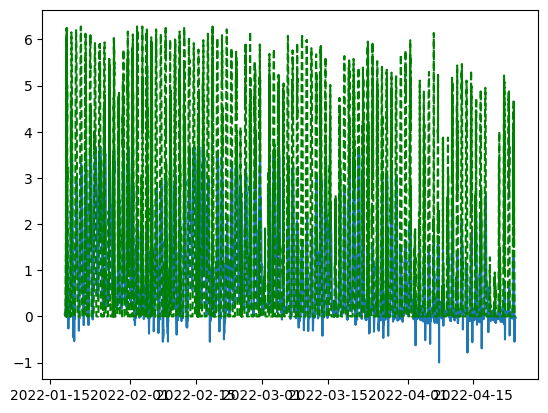

In [75]:
plt.plot(pd.Series(index=y_test[0:9198].index,data=prediction.flatten()))
plt.plot(y_test,color='green', linestyle='dashed')

In [63]:
len(y_test)

9202

In [64]:
len(prediction)

9198

Timestamp
2022-01-18 03:30:00    0.055739
2022-01-18 03:45:00    0.041916
2022-01-18 04:00:00    0.032080
2022-01-18 04:15:00    0.017995
2022-01-18 04:30:00    0.041796
                         ...   
2022-04-23 21:45:00   -0.027771
2022-04-23 22:00:00   -0.027095
2022-04-23 22:15:00   -0.027095
2022-04-23 22:30:00   -0.027095
2022-04-23 22:45:00   -0.027095
Length: 9198, dtype: float32

array([ 0.05573925,  0.0419158 ,  0.03207999, ..., -0.02709466,
       -0.02709481, -0.0270949 ], dtype=float32)